In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import sys
# import tensorflow_addons as tfa
# from tfa.layers import flatten
%matplotlib inline

In [2]:
training_file = "data/train.pickle"
validation_file= "data/valid.pickle"
testing_file = "data/test.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid[0].shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test.shape)

X_train shape: (32, 32, 3)
y_train shape: (34799,)
X_valid shape: (32, 32, 3)
y_valid shape: (4410,)
X_test shape: (32, 32, 3)
y_test shape: (12630,)


In [3]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

In [4]:
print("Number of training examples = ", n_train)
print("Number of validation example = ", n_valid)
print("Number of testing samples = ", n_test)
print("Shape of first training image = ", image_shape[0], "w x", image_shape[1], "h x", image_shape[2], "d")
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation example =  4410
Number of testing samples =  12630
Shape of first training image =  32 w x 32 h x 3 d
Number of classes =  43


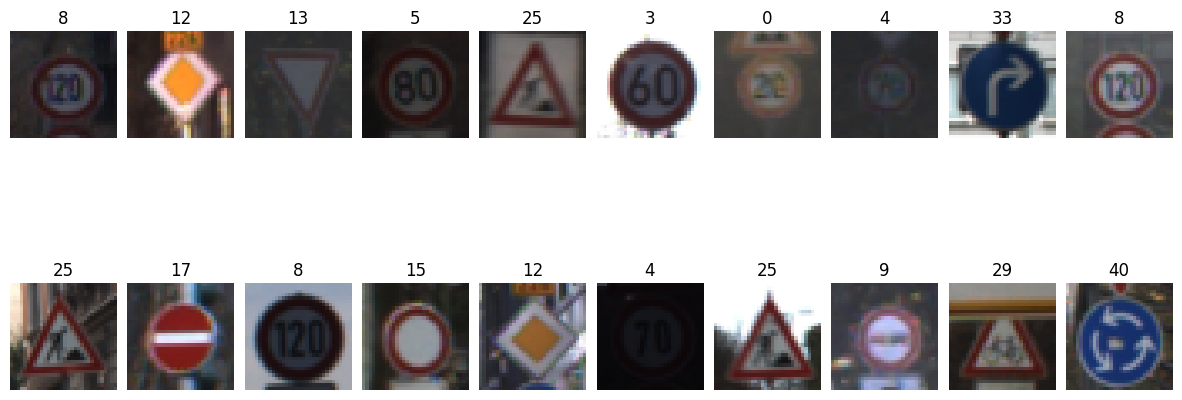

In [5]:
fig, axs = plt.subplots(2,10, figsize=(15,6))
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

for i in range(20):
    index = random.randint(0,len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

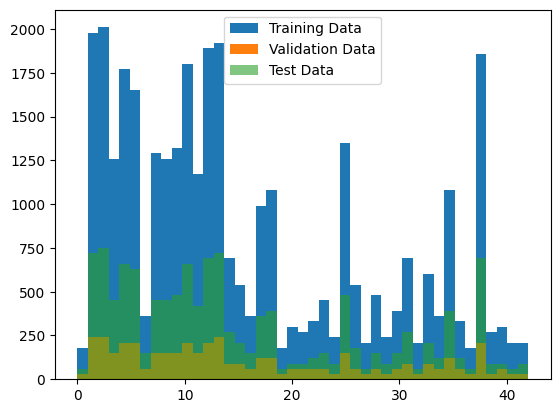

In [6]:
a = y_train
b = y_valid
c = y_test
bins = n_classes

plt.hist(a, bins, alpha=1, label='Training Data')
plt.hist(b, bins, alpha=1, label='Validation Data')
plt.hist(c, bins, alpha=0.6, label='Test Data')
plt.legend(loc='upper center')

plt.show()

In [7]:
# rotation

degrees = 10
degrees_positive = 10
degrees_negative = 350
X_train_rotated_positive = []
X_train_rotated_negative = []

for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_positive)
    X_train_rotated_positive.append(rotated_image)

for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_negative)
    X_train_rotated_negative.append(rotated_image)

for i in range(len(X_train_rotated_positive)):
    X_train_rotated_positive[i] = X_train_rotated_positive[i][2:34,2:34]

for i in range(len(X_train_rotated_negative)):
    X_train_rotated_negative[i] = X_train_rotated_negative[i][2:34,2:34]

X_train = list(X_train)

for i in range(len(X_train_rotated_positive)):
    X_train.append(X_train_rotated_positive[i])
    X_train.append(X_train_rotated_negative[i])

y_train = list(y_train)

for i in range(len(y_train)):
    y_train.append(y_train[i])
    y_train.append(y_train[i])

X_train = np.array(X_train)
new_n_train = len(X_train)

y_train = np.array(y_train)
new_n_train_y = len(y_train)

print("New number of ground truth labels = ", new_n_train_y)
print("New number of training samples after data augmentation = ", new_n_train)

New number of ground truth labels =  104397
New number of training samples after data augmentation =  104397


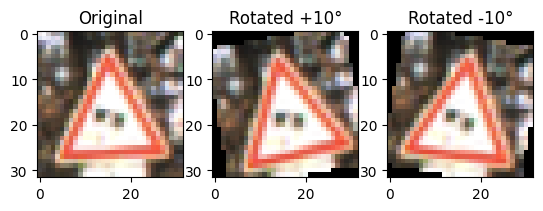

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(X_train[2018])
ax1.set_title('Original')
ax1.axis('ON')
ax2.imshow(X_train_rotated_positive[2018])
ax2.set_title('Rotated +10°')
ax2.axis('ON')
ax3.imshow(X_train_rotated_negative[2018])
ax3.set_title('Rotated -10°')
ax3.axis('ON')
plt.savefig('./examples/Figure_original_rotated.jpg', dpi=300)
plt.show()

In [9]:
X_train, y_train = shuffle(X_train, y_train)

print("shuffle complete")

shuffle complete


In [10]:
def normalize(image):
    normal = (image - 127.5)/255
    return np.reshape(normal, (32,32,1))

In [11]:
def grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return np.reshape(gray, (32,32,1))

In [12]:
def equalize(image):
    equal = cv2.equalizeHist(image)
    return np.reshape(equal, (32,32,1))

In [13]:
X_train_normalized = []

for image in X_train:
    gray_image = grayscale(image)
    equal_image = equalize(gray_image)
    normalized_image = normalize(equal_image)
    X_train_normalized.append(normalized_image)

In [14]:
X_valid_normalized = []

for image in X_valid:
    gray_image = grayscale(image)
    equal_image = equalize(gray_image)
    normalized_image = normalize(equal_image)
    X_valid_normalized.append(normalized_image)

In [15]:
X_test_normalized = []

for image in X_test:
    gray_image = grayscale(image)
    equal_image = equalize(gray_image)
    normalized_image = normalize(equal_image)
    X_test_normalized.append(normalized_image)

In [16]:
print('completed')

completed


In [17]:
def LeNet(x, keep_prob):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b
    print("Shape after 1st convolutional layer: ", conv1.shape)
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    print("Shape after first pooling: ", conv1.shape)

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    print("Shape after 1st convolutional layer: ", conv2.shape)
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    print("Shape after first pooling: ", conv2.shape)

    fc0 = tf.layers.Flatten(conv2)

    # fc0 = tf.compat.flatten(conv2)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,200), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    print("Shape after first fully connected layer: ", fc1.shape)

    fc1 = tf.nn.relu(fc1)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    print("Shape after second fully connected layer: ", fc2.shape)

    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    print("Shape after dropout: ", fc2.shape)

    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print("Shape of Logits after third fully connected layer: ", logits.shape)

    return logits

In [18]:
print("completed")

completed


In [20]:
# hyperparameters

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

keep_prob = 1.0
epochs = 50
batch = 100
rate = 0.001
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

Instructions for updating:
non-resource variables are not supported in the long term


In [23]:
# pipeline
import tensorflow as tf

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

AttributeError: module 'tensorflow' has no attribute 'truncated_normal'

In [24]:
# evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch):
        batch_x, batch_y = X_data[offset:offset+batch], y_data[offset:offset+batch]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

NameError: name 'logits' is not defined

In [25]:
# training

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...\n")
    for i in range(epochs):
        X_train_normalized, y_train = shuffle()

AttributeError: module 'tensorflow' has no attribute 'Session'